<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Make-KNN" data-toc-modified-id="Make-KNN-5">Make KNN</a></span></li><li><span><a href="#Backup" data-toc-modified-id="Backup-6">Backup</a></span><ul class="toc-item"><li><span><a href="#covid-acute-vs-healthy-(test)" data-toc-modified-id="covid-acute-vs-healthy-(test)-6.1">covid acute vs healthy (test)</a></span></li></ul></li><li><span><a href="#SS" data-toc-modified-id="SS-7">SS</a></span></li><li><span><a href="#CHOP-samples" data-toc-modified-id="CHOP-samples-8">CHOP samples</a></span></li></ul></div>

# Dependencies

In [1]:
pacman::p_load(igraph, graphlayouts, ggraph, ggforce, dplyr)

# Functions

In [2]:
#source("/Users/anabbi/git/ped_CapTCRseq/R/Immune_diversity.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/"

# Main

In [30]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [5]:
load(file = paste0(datapath, "capTCRseq/gliph_int_covid_tcr.RData"))

In [6]:
gliphoutput <- read.csv(paste0(h4hpath,'/GLIPH/int_covid_tcr_cluster.csv'), header = T)

In [7]:
dim(gliphoutput)

[1] 301942     29

In [8]:
head(gliph_int_covid_tcr)

,CDR3b,TRBV,TRBJ,CDR3a,subject:condition,count,clonefraction,subject,file,index
,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,CAIRDPEQGITDTQYF,TRBV10-3,TRBJ2-3,NA,CHP_315:1,24,0.025369979,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,1
2,CAIRGTGADQPQHF,TRBV10-3,TRBJ1-5,NA,CHP_315:2,21,0.022198732,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,2
3,CAISGVWGGDTQYF,TRBV10-3,TRBJ2-3,NA,CHP_315:3,12,0.012684989,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,3
4,CASRLAGTGSPLHF,TRBV6-1,TRBJ1-6,NA,CHP_315:4,2,0.002114165,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,4
5,CASSDPQGTEAFF,TRBV6-2,TRBJ1-1,NA,CHP_315:5,21,0.022198732,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,5
6,CASSEEPGTSGYNEQFF,TRBV2,TRBJ2-1,NA,CHP_315:6,6,0.006342495,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,6


map back to the original data

In [9]:
gliph_all <- merge(gliph_int_covid_tcr, gliphoutput, 
                   by.x = "subject:condition", by.y = "Sample", all = T)

In [10]:
dim(gliphoutput)

[1] 301942     29

In [11]:
#remove HLA cols they are empty
HLAcol <- colnames(gliph_all)[!grepl("HLA", colnames(gliph_all))]
gliph_all <- gliph_all[, ..HLAcol]

In [12]:
colnames(gliph_all)

[1] "subject:condition"  "CDR3b"              "TRBV"              
 [4] "TRBJ"               "CDR3a"              "count"             
 [7] "clonefraction"      "subject"            "file"              
[10] "index.x"            "index.y"            "pattern"           
[13] "Fisher_score"       "number_subject"     "number_unique_cdr3"
[16] "final_score"        "hla_score"          "vb_score"          
[19] "expansion_score"    "length_score"       "cluster_size_score"
[22] "type"               "TcRb"               "V"                 
[25] "J"                  "TcRa"               "Freq"

In [13]:
gliph_int <- gliph_all[grepl(paste(c("CHP", "LFS"),
                                       collapse = "|"), gliph_all$`subject:condition`),]

In [14]:
#if pattern is NA = not clustered
gliph_int$pattern[ is.na(gliph_int$pattern)] <- "Not clustered"

In [15]:
# just to consider those cdr3s with the same sequence but different VJ
#gliph_chp$CDR3_VJ <- paste(gliph_chp$CDR3b, gliph_chp$TRBV, gliph_chp$TRBJ, sep = "_")

In [15]:
#if subject contains more than one sample == public
#gliph_int$subject[ grepl(",", gliph_int$subject)] <- "public"

In [ ]:
#create sampleid from subject:condition. This may not account for those common cdr3s and just get one sample. 
# For later try the following: input gliph should be all unique cdr3s. All common cdr3s will be in column subject with sample_ids separated by ,
## merge gliph output with input. then separate_rows() by , in the subject to get rows with common cdr3s for each cluster
### This avoids having lots of single clusters that we may have to remove later


In [43]:
gliph_int$sampleID <- gsub(":.*", "", gliph_int$`subject:condition`)

gliph_int$sampleID <- gsub("-", "_", gliph_int$sampleID)

In [17]:
#remove single or notclustered
gliph_int <- gliph_int[!gliph_int$pattern %in% c("single", "Not clustered"),]

In [18]:
dim(gliph_int)

[1] 90375    27

In [19]:
# filter
gliph_int <- gliph_int[ gliph_int$number_subject >= 3,]
gliph_int <- gliph_int[ gliph_int$number_unique_cdr3 >= 3,]
gliph_int <- gliph_int[ gliph_int$Fisher_score < 1e-04,]

In [20]:
dim(gliph_int)

[1] 1863   27

In [44]:
gliph_data_matrix_df <- as.data.frame.matrix(table(gliph_int %>% select(type , TcRb)))

In [45]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix(gliph_data_matrix_df, weighted = T )

In [46]:
head(V(gliph_data_igrf)$name)

[1] "global-%DGNTGE" "global-%DQNTGE" "global-%DRNTGE" "global-%DSNTGE"
[5] "global-%EANTGE" "global-%EQNTGE"

In [47]:
V(gliph_data_igrf)$subject <- sapply(V(gliph_data_igrf)$name, function(x){
    gliph_int$sampleID[match(x, gliph_int$TcRb)]})

In [48]:
V(gliph_data_igrf)$subject[is.na(V(gliph_data_igrf)$subject)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$subject)], function(x){
    gliph_int$sampleID[match(x, gliph_int$type)]
})


In [49]:
head(V(gliph_data_igrf)$subject)

[1] "CHP_349" "CHP_359" "CHP_351" "CHP_371" "CHP_359" "CHP_387"

In [50]:
V(gliph_data_igrf)$cancergroup <- sapply(V(gliph_data_igrf)$subject, function(x){
    meta_div$cancergroup[match(x, meta_div$Patient)]
}
                                    )

In [54]:
table(V(gliph_data_igrf)$cancergroup)


Leukemia Lymphoma    Solid 
     812       81      345 

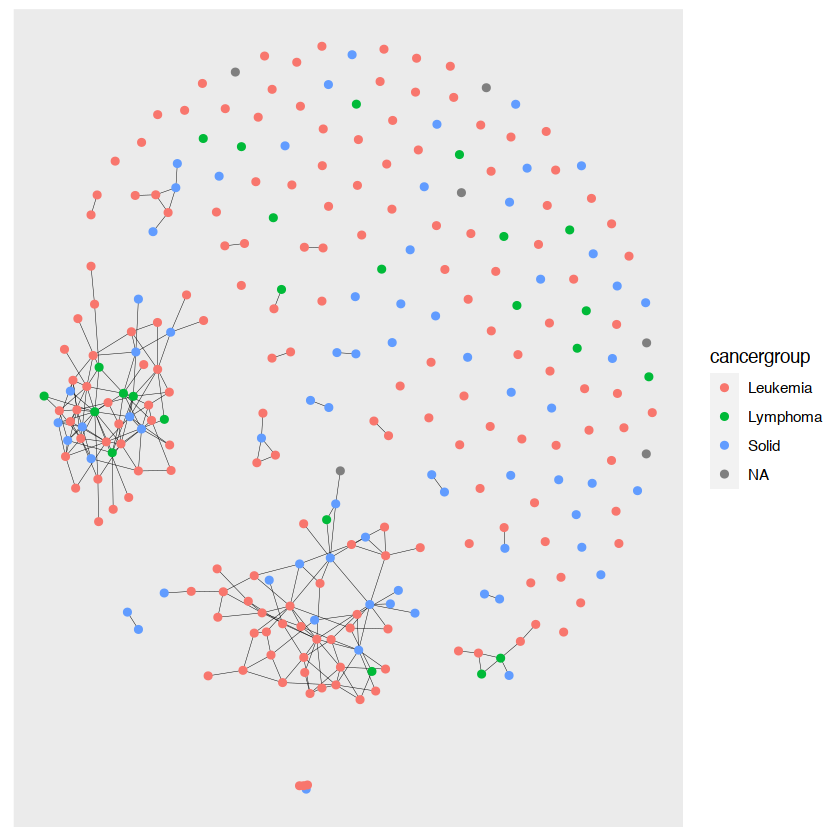

In [57]:
ggraph(bipartite.projection(gliph_data_igrf)$proj1 , "fr", weights = NULL ) +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + geom_node_point(aes(color = cancergroup))

# Make KNN

In [127]:
neighbors(bipartite.projection(gliph_data_igrf)$proj1, "global-%DGNTGE")

+ 2/271 vertices, named, from 0bf2947:
[1] global-GD%NTGE global-SD%NTGE

In [145]:
myg <- (bipartite.projection(gliph_data_igrf)$proj1)

In [149]:
neighbors(myg, "global-%GGPYTGE")

+ 0/271 vertices, named, from 875bba0:

In [151]:
myg1 <- delete_vertices( myg, degree(myg) == 0)

In [152]:
degree(myg1)

global-%DGNTGE       global-%DRNTGE       global-%DSNTGE 
                   2                    1                    2 
      global-%EANTGE       global-%EQNTGE           global-%NE 
                   1                    2                    1 
      global-%NLNTGE      global-%QGPYTGE      global-%RDRNTGE 
                   1                    1                    1 
      global-GD%NTGE           global-N%E       global-Q%MNTGE 
                   1                    1                    1 
      global-QG%NTGE       global-S%AGAYE         global-S%AGE 
                   1                    1                    8 
     global-S%AGGPNE         global-S%ANE      global-S%DRNTGE 
                   1                    2                    1 
        global-S%GAE         global-S%GGE        global-S%GGGE 
                   6                   15                    4 
       global-S%GGNE        global-S%GGRE        global-S%GGTE 
                   7                    3                    6 
       global-S%GGVE        global-S%GGYE         global-S%GLE 
                   2                    6                    5 
     global-S%GPYTGE     global-S%GQGISYE         global-S%GSE 
                   1                    1                    6 
       global-S%GSGE         global-S%GTE     global-S%GTGFSYE 
                   2                    7                    1 
        global-S%GYE        global-S%MGNE       global-S%QNTGE 
                   5                    1                    2 
      global-S%RSAGE         global-S%SGE        global-S%SGTE 
                   1                    8                    2 
        global-S%SNE         global-S%SSE         global-S%SYE 
                   1                    4                    4 
       global-S%TGAE         global-S%TGE        global-S%TGFE 
                   1                    4                    1 
       global-S%TGGE        global-S%TGYE         global-S%WGE 
                   3                    4                    1 
    global-SAGQG%SYE         global-SAS%E       global-SD%DTGE 
                   1                    1                    1 
      global-SD%NTGE         global-SD%YE      global-SDR%STDT 
                   4                    1                    1 
     global-SDRG%TDT       global-SDS%TGE         global-SE%GE 
                   1                    3                    6 
      global-SE%NTGE         global-SEG%E         global-SELG% 
                   3                    5                    1 
        global-SF%AE         global-SF%DE         global-SF%GE 
                   2                    2                    7 
       global-SF%GNE        global-SF%GTE        global-SF%GYE 
                   2                    3                    4 
        global-SF%NE         global-SF%SE         global-SFA%E 
                   1                    2                    2 
        global-SFG%E        global-SFGG%E         global-SFS%E 
                   8                    7                    7 
        global-SFSG%        global-SFTG%E       global-SIRS%GE 
                   3                    4                    1 
        global-SL%DE        global-SL%GAE       global-SL%GAGE 
                   1                    2                    3 
       global-SL%GDE         global-SL%GE        global-SL%GGE 
                   3                   10                    9 
       global-SL%GLE        global-SL%GNE        global-SL%GPE 
                   1                    8                    2 
       global-SL%GSE         global-SL%SE        global-SL%SGE 
                   3                    4                    4 
       global-SL%TYE         global-SLA%E         global-SLAG% 
                   1                    4                    3 
       global-SLAG%E        global-SLAG%G       global-SLAG%GE 
                   7                    1                    3 
       global-SLAGA%       global-SLAG

In [159]:
myk <- cluster_louvain(myg1, resolution = 1)

In [162]:
head(myk$membership)

[1] 1 1 1 2 2 3

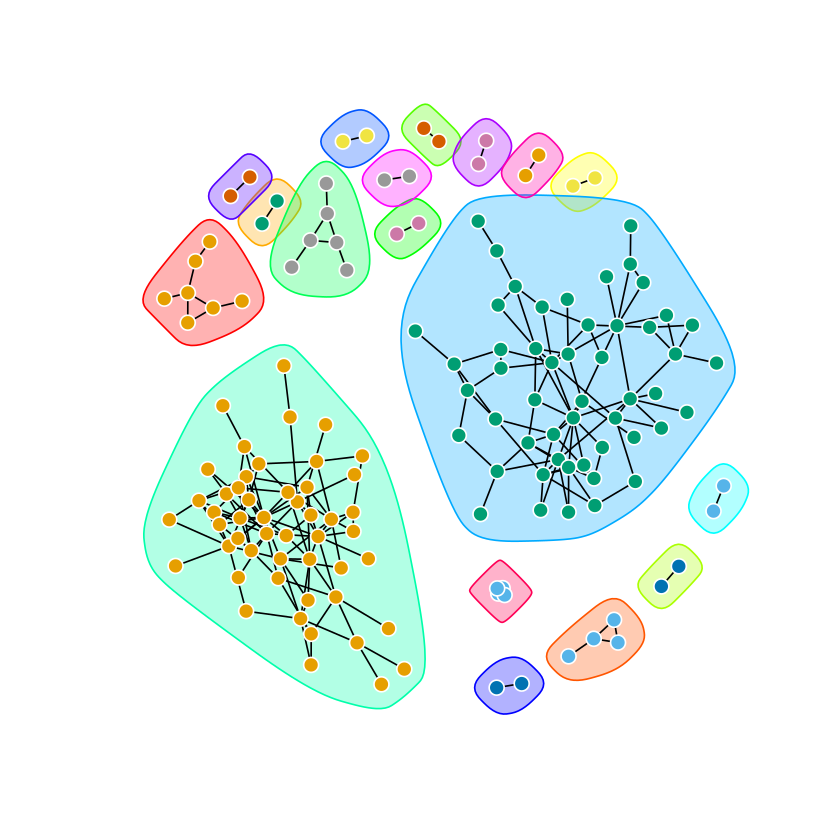

In [172]:
plot(myk, myg1, vertex.label=NA, vertex.frame.color="white", vertex.size=5)

In [167]:
V(myg1)$community <- as.character(myk$membership)


#plot(myg1, vertex.color=colrs[V(net)$community])

Warning message:
“Removed 1 rows containing missing values (geom_point).”


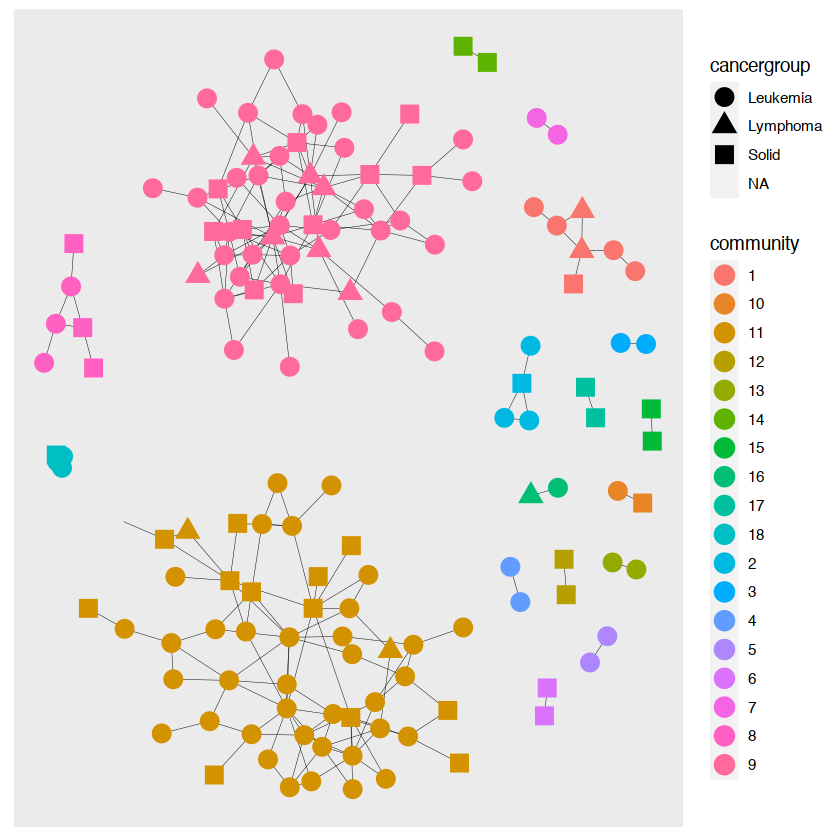

In [168]:
ggraph(myg1 , "fr", weights = NULL ) +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + 
geom_node_point(aes(shape = cancergroup, color = community), size = 5)

In [131]:
(bipartite.projection(gliph_data_igrf)$proj1)

IGRAPH 796c2ad UNW- 271 232 -- 
+ attr: name (v/c), subject (v/c), cancergroup (v/c), weight (e/n)
+ edges from 796c2ad (vertex names):
 [1] global-%DGNTGE --global-GD%NTGE  global-%DGNTGE --global-SD%NTGE 
 [3] global-%DRNTGE --global-SD%NTGE  global-%DSNTGE --global-SD%NTGE 
 [5] global-%DSNTGE --global-SDS%TGE  global-%EANTGE --global-SE%NTGE 
 [7] global-%EQNTGE --global-S%QNTGE  global-%EQNTGE --global-SE%NTGE 
 [9] global-%NE     --global-N%E      global-%NLNTGE --global-T%LNTGE 
[11] global-%QGPYTGE--global-S%GPYTGE global-%RDRNTGE--global-S%DRNTGE
[13] global-Q%MNTGE --global-QG%NTGE  global-S%AGAYE --global-SLAGA%E 
[15] global-S%AGE   --global-SE%GE    global-S%AGE   --global-SF%GE   
+ ... omitted several edges

In [129]:
neighbors(bipartite.projection(gliph_data_igrf)$proj1, "global-GD%NTGE")

+ 1/271 vertex, named, from 5bc8fe3:
[1] global-%DGNTGE

In [107]:
neighbors(gliph_data_igrf, "global-SEG%E")

+ 11/1273 vertices, named, from b6aa1a2:
 [1] CAISEGGEQYF CAISEGNEQFF CAISEGREQYF CAISEGTEAFF CAISEGYEQYF CASSEGAEAFF
 [7] CASSEGDEQFF CASSEGNEQFF CASSEGYEQYF CATSEGTEAFF CSASEGREQYF

In [102]:
knn_k <- knn(bipartite.projection(gliph_data_igrf)$proj1, weights = NA, mode = "all", )

In [95]:
E(gliph_data_igrf)[ V(gliph_data_igrf)$name == "global-S%GAE"]

+ 2/1484 edges from b6aa1a2 (vertex names):
[1] global-G%MNTGE      --CASGSMNTGELFF    
[2] motif-IWV motif-IWVY--CASSSGKAGIWVYEQYF

In [103]:
knn_k

$knn
      global-%DGNTGE       global-%DQNTGE       global-%DRNTGE 
            2.500000                  NaN             4.000000 
      global-%DSNTGE       global-%EANTGE       global-%EQNTGE 
            3.500000             3.000000             2.500000 
          global-%ET      global-%GGPYTGE      global-%GQSSYNE 
                 NaN                  NaN                  NaN 
   global-%KLAPSSYNE           global-%NE       global-%NLNTGE 
                 NaN             1.000000             1.000000 
     global-%QGPYTGE      global-%RDRNTGE          global-%SYE 
            1.000000             1.000000                  NaN 
      global-%TLNTGE     global-ALAGG%YNE       global-G%ANTGE 
                 NaN                  NaN                  NaN 
      global-G%ENTGE       global-G%LNTGE       global-G%MNTGE 
                 NaN                  NaN                  NaN 
      global-G%SNTGE       global-GD%NTGE       global-GQ%NTGE 
                 NaN             2.000000                  NaN 
      global-HGG%SYE           global-N%E       global-Q%ANTGE 
                 NaN             1.000000                  NaN 
      global-Q%MNTGE       global-QG%NTGE      global-R%GGAQET 
            1.000000             1.000000                  NaN 
      global-RD%INYG     global-RGLAG%SYE     global-RGLAGG%YE 
                 NaN                  NaN                  NaN 
      global-RGT%TDT            global-S%       global-S%AGAYE 
                 NaN                  NaN             3.000000 
        global-S%AGE      global-S%AGGPNE         global-S%ANE 
            5.375000             1.000000             4.000000 
        global-S%DIE      global-S%DRNTGE      global-S%DSGGNE 
                 NaN             1.000000                  NaN 
     global-S%ESSYNE         global-S%GAE        global-S%GATE 
                 NaN             6.000000                  NaN 
        global-S%GDT        global-S%GGAE         global-S%GGE 
                 NaN                  NaN             6.000000 
       global-S%GGGE       global-S%GGKDE        global-S%GGNE 
            7.750000                  NaN             5.571429 
       global-S%GGRE        global-S%GGTE        global-S%GGVE 
            7.333333             5.333333             7.500000 
       global-S%GGYE     global-S%GHPSTDT         global-S%GLE 
            5.833333                  NaN             7.600000 
     global-S%GPYTGE        global-S%GQET     global-S%GQGISYE 
            1.000000                  NaN             1.000000 
        global-S%GSE        global-S%GSGE         global-S%GTE 
            6.000000             5.000000             6.571429 
    global-S%GTGFSYE     global-S%GTGISYE     global-S%GTGLSYE 
            1.000000                  NaN                  NaN 
      global-S%GVEET         global-S%GYE     global-S%LAGGPNE 
                 NaN             6.400000                  NaN 
       global-S%MGNE        global-S%MNTE          global-S%NE 
            8.000000                  NaN                  NaN 
       global-S%PGNE       global-S%PNTGE       global-S%QNTGE 
                 NaN                  NaN             2.500000 
     global-S%RDGTDT      global-S%RGPADT      global-S%RGPNEK 
                 NaN                  NaN                  NaN 
     global-S%RGPTDT    global-S%RQGVNTGE       global-S%RSAGE 
                 NaN                  NaN             1.000000 
      global-S%RSTGE         global-S%SGE        global-S%SGEK 
                 NaN             6.250000                  NaN 
      global-S%SGGYE        global-S%SGSE        global-S%SGTE 
                 NaN                  NaN             3.500000 
        global-S%SNE         global-S%SSE         global-S%SYE 
            6.000000             4.750000             3.750000 
      global-S%TDTGE        global-S%TGAE        global-S%TGDE 
                 NaN             4.000000                  NaN 
        global-S%TGE       

In [99]:
generate.knn

ERROR: Error in eval(expr, envir, enclos): object 'generate.knn' not found


In [97]:
g3 <- sample_pa(1000, m=5)
k <- knn(g3)

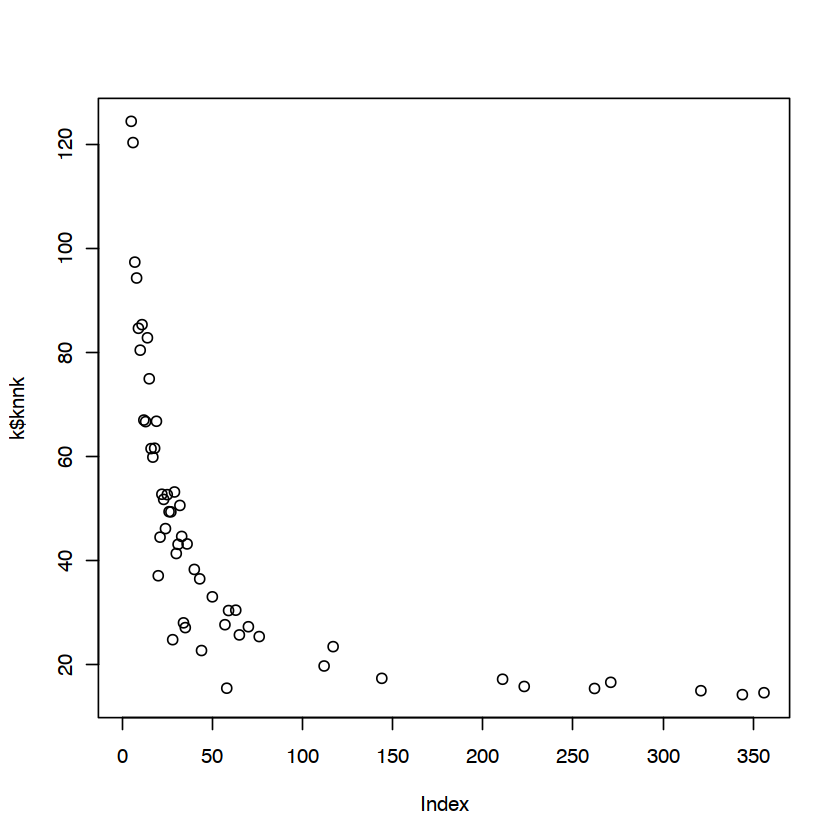

In [98]:
plot(k$knnk)

# Backup

## covid acute vs healthy (test)

In [12]:
gliph_covid <- gliph_all[grepl(paste(c("eJL158", "eXL36"), #1 COVID+, 1 Healthy
                                       collapse = "|"), gliph_all$`subject:condition`),]

In [13]:
#if pattern is NA = not clustered
gliph_covid$pattern[ is.na(gliph_covid$pattern)] <- "Not clustered"

In [14]:
# just to consider those cdr3s with the same sequence but different VJ
gliph_covid$CDR3_VJ <- paste(gliph_covid$CDR3b, gliph_covid$TRBV, gliph_covid$TRBJ, sep = "_")

In [15]:
#if subject contains more than one sample == public
gliph_covid$subject[ grepl(",", gliph_covid$subject)] <- "public"

In [16]:
#remove Not clustered to create an edge list
gliph_covid_clustered <- gliph_covid[ gliph_covid$pattern != "Not clustered",]

In [20]:
colnames(gliph_covid_clustered)

[1] "subject:condition"  "CDR3b"              "TRBV"              
 [4] "TRBJ"               "CDR3a"              "count"             
 [7] "clonefraction"      "subject"            "file"              
[10] "index.x"            "index.y"            "pattern"           
[13] "Fisher_score"       "number_subject"     "number_unique_cdr3"
[16] "final_score"        "hla_score"          "vb_score"          
[19] "expansion_score"    "length_score"       "cluster_size_score"
[22] "type"               "TcRb"               "V"                 
[25] "J"                  "TcRa"               "Freq"              
[28] "CDR3_VJ"

In [18]:
#from stackoverflow to find all combos for each pattern
edgedf <- gliph_covid_clustered %>% group_by(pattern) %>%
  filter(n()>=2) %>% do(data.frame(t(combn(.$CDR3_VJ, 2)), stringsAsFactors=FALSE)) %>% ungroup()

In [21]:
head(edgedf)

pattern,X1,X2
<chr>,<chr>,<chr>
%AANTGE,CAVGAANTGELFF_TRBV07-09_TRBJ02-02,CASGAANTGELFF_TRBV07-09_TRBJ02-02
%DANTGE,CANQDANTGELFF_TRBV06-06_TRBJ02-02,CASDDANTGELFF_TRBV07-08_TRBJ02-02
%DLNTGE,CATGDLNTGELFF_TRBV15-01_TRBJ02-02,CATQDLNTGELFF_TRBV06-X_TRBJ02-02
%DLNTGE,CATGDLNTGELFF_TRBV15-01_TRBJ02-02,CARADLNTGELFF_TRBV07-08_TRBJ02-02
%DLNTGE,CATQDLNTGELFF_TRBV06-X_TRBJ02-02,CARADLNTGELFF_TRBV07-08_TRBJ02-02
%DQNTGE,CAISDQNTGELFF_TRBV12-03/12-04_TRBJ02-02,CATQDQNTGELFF_TRBV06-04_TRBJ02-02


In [20]:
#create vertex list
vertexdf <- gliph_covid[,c("CDR3_VJ", "count", "subject")]
vertexdf <- vertexdf[!duplicated(vertexdf$CDR3_VJ),]

In [21]:
gliph_data_igrf <- graph_from_data_frame(d = edgedf[, c("X1", "X2", "pattern")], 
                                         vertices = vertexdf, directed = FALSE)

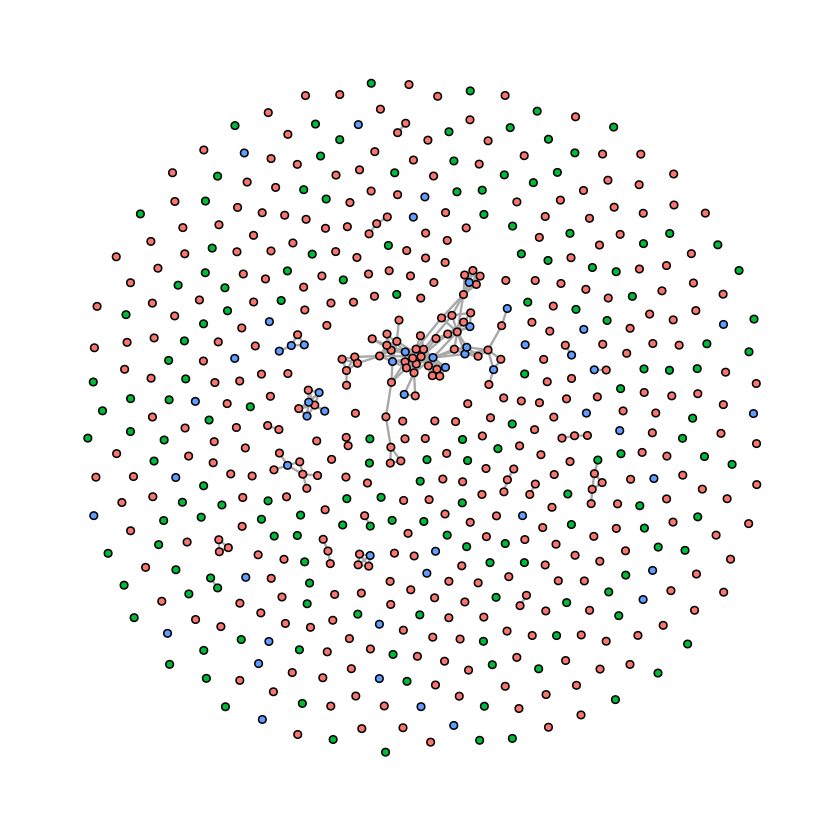

In [22]:
set.seed(1)
ggraph(gliph_data_igrf, layout = "graphopt") + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66") +
  geom_node_point(aes(fill = subject), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph() +
  theme(legend.position = "none")

In [24]:
summary(degree(gliph_data_igrf))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.8094  0.0000 17.0000 

In [122]:
gliph_data_igrf1 <- delete.vertices(gliph_data_igrf, which(degree(gliph_data_igrf) == 0))

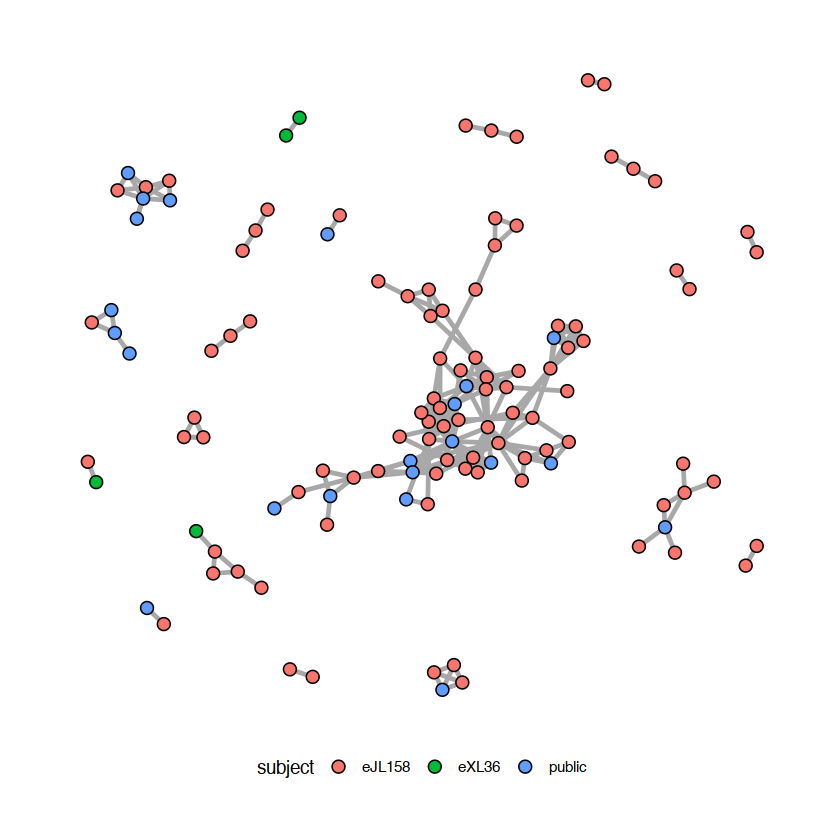

In [127]:
set.seed(1)
ggraph(gliph_data_igrf1, layout = "graphopt") + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66", width = 1) +
  geom_node_point(aes(fill = subject), shape = 21, size = 3) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph(base_family="sans") +
  theme(legend.position = "bottom") 

# SS

In [22]:
gliph_data_matrix_df <- as.data.frame.matrix(
                table(gliph_covid %>% select(type , TcRb )))

In [23]:
head(gliph_data_matrix_df)

,CAAGHANTGELFF,CAEGGRNTGELFF,CAGGQLNTGELFF,CAGQESNTGELFF,CAGQSSNTGELFF,CAGSDQNTGELFF,CAISDQNTGELFF,CAISEGTTGNEQFF,CAMQEMNTGELFF,CANQDANTGELFF,⋯,CSGRADTQYF,CSRGSPDTQYF,CSVDFRGSGTEAFF,CSVDGGGEQYF,CSVDGTVNTEAFF,CSVDLDRNTGELFF,CSVEEGRSYNEQFF,CSVTAGGPRDEQFF,CSVTGNTEAFF,CSVVDRSSYNEQFF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
global-%AANTGE,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
global-%ADT,0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
global-%AGFNE,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
global-%AINTGE,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
global-%DANTGE,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
global-%DGNTGE,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [51]:
?graph_from_incidence_matrix

In [55]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix (gliph_data_matrix_df, weighted = T )

In [64]:
gliph_data_igrf <- delete.vertices(gliph_data_igrf, which(degree(gliph_data_igrf) <= 1))

In [65]:
V(gliph_data_igrf)$subject <- sapply(V(gliph_data_igrf)$name, function(x){
    gliph_covid$subject[match(x, gliph_covid$TcRb)]
}
                                    )

In [66]:
head(V(gliph_data_igrf)$subject[is.na(V(gliph_data_igrf)$subject)])

[1] NA NA NA NA NA NA

In [67]:
V(gliph_data_igrf)$subject[is.na(V(gliph_data_igrf)$subject)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$subject)], function(x){
    gliph_covid$subject[match(x, gliph_covid$type)]
}
                                    )

In [68]:
igraph::bipartite.projection(gliph_data_igrf)$proj1

IGRAPH 28a3a59 UNW- 75 87 -- 
+ attr: name (v/c), subject (v/c), weight (e/n)
+ edges from 28a3a59 (vertex names):
 [1] global-%AANTGE--global-G%ANTGE global-%AANTGE--global-GA%NTGE
 [3] global-%DANTGE--global-QD%NTGE global-%DLNTGE--global-G%LNTGE
 [5] global-%DLNTGE--global-Q%LNTGE global-%DLNTGE--global-QD%NTGE
 [7] global-%DQNTGE--global-S%QNTGE global-%DQNTGE--global-SD%NTGE
 [9] global-%DQNTGE--global-SDQ%TGE global-%DQNTGE--global-SDQN%GE
[11] global-%DQNTGE--global-QD%NTGE global-%DTNTGE--global-Q%TNTGE
[13] global-%DTNTGE--global-QD%NTGE global-%EGNTGE--global-QE%NTGE
[15] global-%ELNTGE--global-Q%LNTGE global-%ELNTGE--global-QE%NTGE
+ ... omitted several edges

In [69]:
igraph::bipartite.projection(gliph_data_igrf)$proj2

IGRAPH e0ad183 UNW- 277 183 -- 
+ attr: name (v/c), subject (v/c), weight (e/n)
+ edges from e0ad183 (vertex names):
 [1] CAAGHANTGELFF--CASGAANTGELFF CAAGHANTGELFF--CATGEANTGELFF
 [3] CAAGHANTGELFF--CATGTANTGELFF CAAGHANTGELFF--CAVGAANTGELFF
 [5] CAAGHANTGELFF--CSFGLANTGELFF CAGGQLNTGELFF--CATGDLNTGELFF
 [7] CAGGQLNTGELFF--CATGELNTGELFF CAGGQLNTGELFF--CATGQMNTGELFF
 [9] CAGQESNTGELFF--CATQESNTGELFF CAGQESNTGELFF--CAGQSSNTGELFF
[11] CAGQESNTGELFF--CATQDSNTGELFF CAGQESNTGELFF--CAMQEMNTGELFF
[13] CAGQESNTGELFF--CASQEGNTGELFF CAGQESNTGELFF--CASQELNTGELFF
[15] CAGQESNTGELFF--CASQERNTGELFF CAGQESNTGELFF--CASQETNTGELFF
+ ... omitted several edges

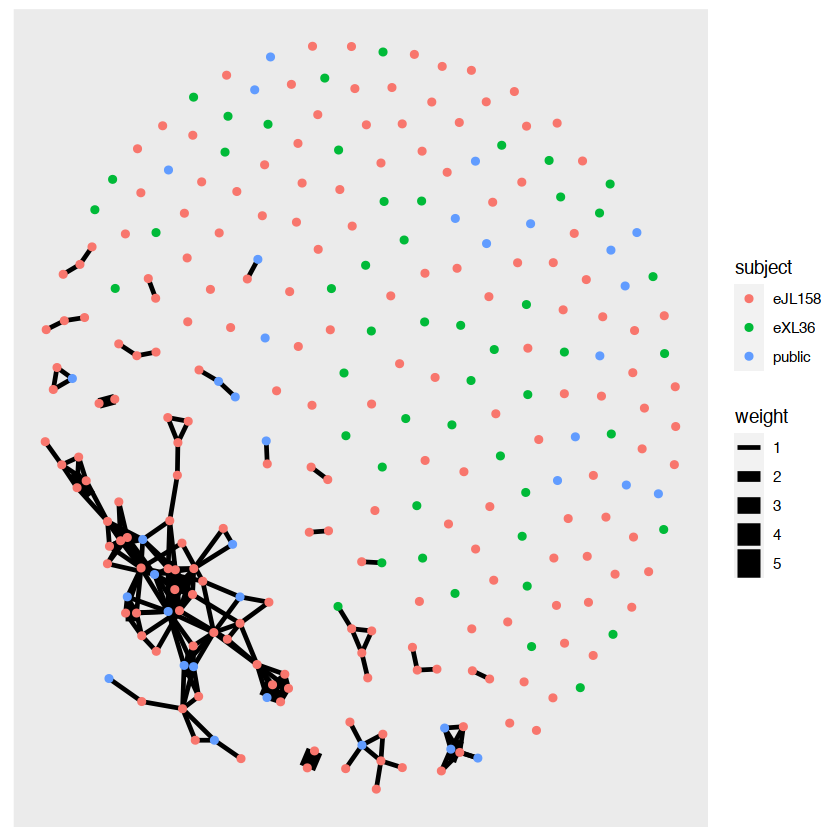

In [89]:
        ggraph(bipartite.projection(gliph_data_igrf)$proj2 , "fr", weights = NULL ) +
        geom_edge_link(aes(edge_width = weight),
                #edge_width = 0.1 ,
                edge_colour = "#000000"
        ) +
        geom_node_point(aes(color = subject))
        

In [74]:
     V(gliph_data_igrf)$CloneCount <- 

sapply(V(gliph_data_igrf)$name, function(x){
   gliph_covid$Freq[ match(gliph_covid$TcRb == V(gliph_data_igrf)$name[i]]) 
})

        for (i in c(1:length(V(gliph_data_igrf)$CloneCount))) {
                
                if (any(gliph_covid$Freq[gliph_covid$TcRb == V(gliph_data_igrf)$name[i]])) {
                        V(gliph_data_igrf)$CloneCount[i] <- gliph_covid$Freq [gliph_covid$TcRb == V(gliph_data_igrf)$name[i]]
                        
                }
                else {
                        V(gliph_data_igrf)$CloneCount[i] <- 0
                }
        }

Warning message in any(gliph_covid$Freq[gliph_covid$TcRb == V(gliph_data_igrf)$name[i]]):
“coercing argument of type 'double' to logical”


ERROR: Error in if (any(gliph_covid$Freq[gliph_covid$TcRb == V(gliph_data_igrf)$name[i]])) {: missing value where TRUE/FALSE needed


# CHOP samples

In [13]:
gliph_chp <- gliph_all[grepl("CHP", gliph_all$`subject:condition`),]

In [14]:
#if pattern is NA = not clustered
gliph_chp$pattern[ is.na(gliph_chp$pattern)] <- "Not clustered"

In [15]:
# just to consider those cdr3s with the same sequence but different VJ
gliph_chp$CDR3_VJ <- paste(gliph_chp$CDR3b, gliph_chp$TRBV, gliph_chp$TRBJ, sep = "_")

In [16]:
#if subject contains more than one sample == public
gliph_chp$subject[ grepl(",", gliph_chp$subject)] <- "public"

In [17]:
#remove Not clustered to create an edge list
# filter
gliph_chp_clustered <- gliph_chp[ gliph_chp$pattern != "Not clustered",]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$pattern != "single",]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$number_subject >= 3,]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$number_unique_cdr3 >= 3,]

gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$Fisher_score < 1e-04,]

In [18]:
dim(gliph_chp_clustered)

[1] 1823   28

In [19]:
#from stackoverflow to find all combos for each pattern
edgedf <- gliph_chp_clustered %>% group_by(pattern) %>%
  filter(n()>=2) %>% do(data.frame(t(combn(.$CDR3_VJ, 2)), stringsAsFactors=FALSE)) %>% ungroup()

In [20]:
head(edgedf)

pattern,X1,X2
<chr>,<chr>,<chr>
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASIDGNTGELFF_TRBV19_TRBJ2-2
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASIDGNTGELFF_TRBV19_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASIDGNTGELFF_TRBV19_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASSDGNTGELFF_TRBV6-4_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2


In [21]:
#create vertex list
vertexdf <- gliph_chp_clustered[,c("CDR3_VJ", "count", "subject")]
vertexdf <- vertexdf[!duplicated(vertexdf$CDR3_VJ),]

In [22]:
gliph_data_igrf <- graph_from_data_frame(d = edgedf[, c("X1", "X2", "pattern")], vertices = vertexdf, directed = FALSE)

In [23]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [24]:
gliph_data_igrf

IGRAPH 43a3609 UN-- 1134 26151 -- 
+ attr: name (v/c), count (v/n), subject (v/c), pattern (e/c)
+ edges from 43a3609 (vertex names):
[1] CASGDGNTGELFF_TRBV7-9_TRBJ2-2 --CASIDGNTGELFF_TRBV19_TRBJ2-2  
[2] CASGDGNTGELFF_TRBV7-9_TRBJ2-2 --CASSDGNTGELFF_TRBV6-4_TRBJ2-2 
[3] CASGDGNTGELFF_TRBV7-9_TRBJ2-2 --CASSDGNTGELFF_TRBV6-4_TRBJ2-2 
[4] CASIDGNTGELFF_TRBV19_TRBJ2-2  --CASSDGNTGELFF_TRBV6-4_TRBJ2-2 
[5] CASIDGNTGELFF_TRBV19_TRBJ2-2  --CASSDGNTGELFF_TRBV6-4_TRBJ2-2 
[6] CASSDGNTGELFF_TRBV6-4_TRBJ2-2 --CASSDGNTGELFF_TRBV6-4_TRBJ2-2 
[7] CASSDRNTGELFF_TRBV11-3_TRBJ2-2--CASSDRNTGELFF_TRBV6-4_TRBJ2-2 
[8] CASSDRNTGELFF_TRBV11-3_TRBJ2-2--CATSDRNTGELFF_TRBV24-1_TRBJ2-2
+ ... omitted several edges

In [25]:
#just to simplify a little bit
gliph_data_igrf1 <- delete.vertices(gliph_data_igrf, which(degree(gliph_data_igrf) < 50))

In [26]:
gliph_data_igrf1

IGRAPH adc0400 UN-- 190 18663 -- 
+ attr: name (v/c), count (v/n), subject (v/c), pattern (e/c)
+ edges from adc0400 (vertex names):
[1] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[2] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[3] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[4] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[5] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[6] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[7] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
[8] CASSDSNTGELFF_TRBV6-4_TRBJ2-2--CASSDSNTGELFF_TRBV6-4_TRBJ2-2
+ ... omitted several edges

In [51]:
V(gliph_data_igrf1)$cancer <- meta_div$Disease_type[ match(V(gliph_data_igrf1)$subject,
                                                          meta_div$basename)]

In [52]:
chp_layout <- create_layout(gliph_data_igrf1, "fr")

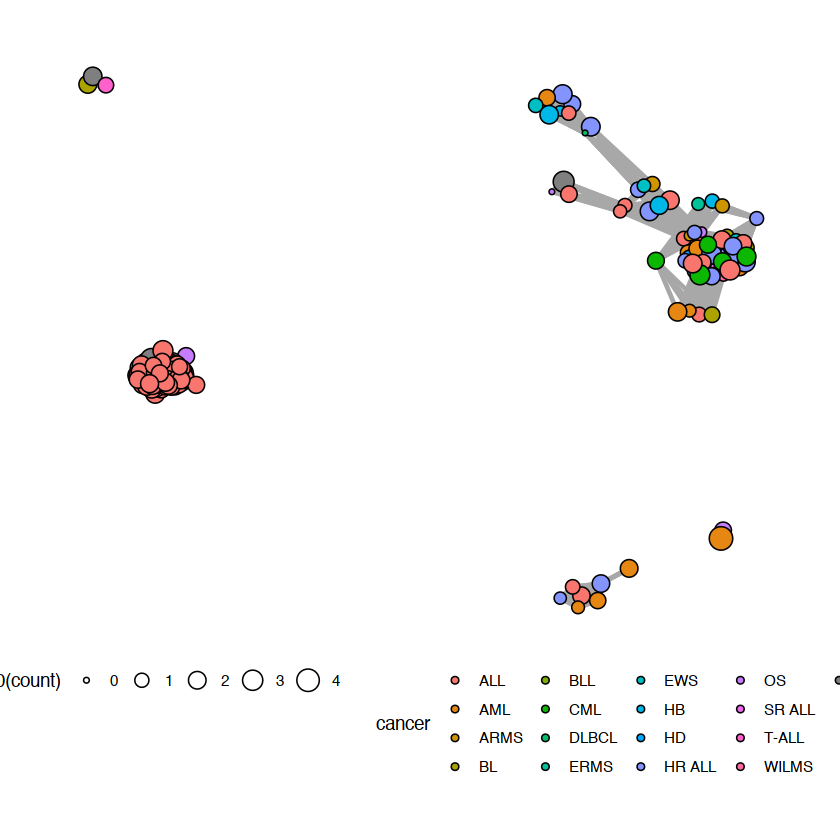

In [53]:
pdf(paste0(plotpath, "chp_graph_mds.pdf"), width = 10, height = 10)
set.seed(1)
ggraph(chp_layout) + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66", width = 1) +
  geom_node_point(aes(fill = cancer, size = log10(count)), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph(base_family="sans") +
  theme(legend.position = "bottom") 

dev.off()